# <center>Option Hedging with Historical Data<center>

<div style="text-align: right;">
    <h2>Yuqian Li</h2>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# <center>Hedging with Historical Data<center>

__<span style="color:blue"> Use yfinance or pandas-datareader (or any other package you’d like) to apply the analysis from the previous questions to real market data. Basically, instead of using simulated data for $S_{t}$, you can plug real one that you have carefully selected to run in your previous
code.</span>__

__<span style="color:blue">You can choose any underlying that you’d like although I would recommend using liquid
names: major market indices (e.g. S&P 500, SX5E, FTSE, NI225) or liquid stocks (e.g.
AAPL, TESLA, AMZN, etc.) or main currency pairs, etc.
Test selling options (not just ATM) and hedging them using Black-Scholes. In particular</span>__

__<span style="color:blue">Conduct hedging and testing in one time window. When testing a hedging strategy, do not use data in the future of test.__</span>

### __Solution:__

__1. For the whole problem, I focus on the 3-year-period: '2020-06-30' ~ '2023-06-30'. In this period,__

'2020-06-30' ~ '2020-12-31' is used for calculating the historical volatility on '2021-01-04'; 

'2021-01-04' ~ '2023-06-30' is used for hedging and testing; 

__2. Construct a time window of 6 month from '2021-01-04' ~ '2021-06-30'. I do hedging and testing for the 6M call option of this period.__

__3. The time window's length `tenor` is 124 days. Rebalance every 4 business days because averagely there are 4 business days in a week. So, there are 31 periods in a time window.__

__4. Roll the 6M period by one business day ahead, do the hedging and testing again, till the 6M window becomes '2023-01-03' ~ '2023-06-30'. This is a 2-year hedging and testing.__   

## Data Preparation

### <center>__Stock Price__ <center>

In [3]:
import yfinance as yf

In [4]:
# Define the stock symbol (I choose Apple: AAPL)
ticker = "AAPL"

# Download historical stock prices
S = yf.download(ticker, start="2020-06-30", end="2023-07-01")

# Download historical dividends data
dividends_data = yf.Ticker(ticker).dividends.loc["2020-06-30":"2023-07-01"]

[*********************100%%**********************]  1 of 1 completed


In [5]:
S = S.reset_index()
S['Date'] = S['Date'].dt.strftime('%Y-%m-%d')
S = S.set_index(['Date'])
S.rename(columns={'Adj Close': 'S'}, inplace=True)
S

,Open,High,Low,Close,S,Volume
Date,,,,,,
2020-06-30,90.019997,91.495003,90.000000,91.199997,89.301910,140223200
2020-07-01,91.279999,91.839996,90.977501,91.027496,89.132996,110737200
2020-07-02,91.962502,92.617500,90.910004,91.027496,89.132996,114041600
2020-07-06,92.500000,93.945000,92.467499,93.462502,91.517326,118655600
2020-07-07,93.852501,94.654999,93.057503,93.172501,91.233360,112424400
...,...,...,...,...,...,...
2023-06-26,186.830002,188.050003,185.229996,185.270004,184.776733,48088700
2023-06-27,185.889999,188.389999,185.669998,188.059998,187.559280,50730800
2023-06-28,187.929993,189.899994,187.600006,189.250000,188.746124,51216800


### <center> __Risk-free Interest Rate__<center> 

__<span style="color:blue">
    • Explain how you choose $r$.</span>__

__1. Get the $r$ data from https://fred.stlouisfed.org.__

__2. I choose the 6M $r$ (abbreviated as DGS6MO), in accordance with the length of the time window: `tenor`.__

__3. For the $P_{0}$, $\Delta_{0}$ of every time window, and the $\Delta_{t}$, $P_{t}$ on every rebalancing day, use the $r$ on the previous day before that very day, because on the rebalancing day, we only know the information before.__

In [ ]:
r = pd.read_excel("r.xlsx")
r['Date'] = r['Date'].dt.strftime('%Y-%m-%d')
r = r.set_index(['Date'])
r = r.loc['2020-06-30':'2023-06-30']
r = r.div(100) #original scale is %
r

### <center>lnS and dS for later calculation<center> 

In [8]:
# compute log
logS = np.log(S["S"] / S["S"].shift(1)).dropna()
logS = logS.to_frame()
logS.rename(columns={'S': 'logS'}, inplace=True)
logS

,logS
Date,
2020-07-01,-0.001893
2020-07-02,0.000000
2020-07-06,0.026399
2020-07-07,-0.003108
2020-07-08,0.023023
...,...
2023-06-26,-0.007582
2023-06-27,0.014947
2023-06-28,0.006308


The meaning of the following `data` dataframe is to exclude the date when one of S and r lacks data.

In [9]:
data = pd.merge(S["S"], r, left_index=True, right_index=True, how='outer')
data = pd.merge(data, logS, left_index=True, right_index=True, how='outer')

data = data.dropna()
#data = data.loc['2020-12-31':]
data

,S,r,logS
Date,,,
2020-07-01,89.132996,0.0017,-0.001893
2020-07-02,89.132996,0.0016,0.000000
2020-07-06,91.517326,0.0016,0.026399
2020-07-07,91.233360,0.0017,-0.003108
2020-07-08,93.358192,0.0017,0.023023
...,...,...,...
2023-06-26,184.776733,0.0545,-0.007582
2023-06-27,187.559280,0.0546,0.014947
2023-06-28,188.746124,0.0547,0.006308


In [10]:
# compute dS = S on that day - S 4 days ago
dS = data["S"]-data["S"].shift(4)
dS = dS.to_frame()
dS.rename(columns={'S': 'dS'}, inplace=True)
dS

,dS
Date,
2020-07-01,NaN
2020-07-02,NaN
2020-07-06,NaN
2020-07-07,NaN
2020-07-08,4.225197
...,...
2023-06-26,0.259323
2023-06-27,4.089066
2023-06-28,2.244003


Here I get the time length for calculating historical volatility.

In [11]:
# time length for calculating historical volatility
len(data.loc[:'2020-12-31'])

126

Here I get the time length of each time window.

In [12]:
# time length of each time window
tenor = len(data.loc['2021-01-04':'2021-06-30'])
tenor

124

### <center>Historical Volatility<center> 

__<span style="color:blue">• Explain how you choose the hedging volatility.</span>__

__1. The first hedging from '2021-01-04' to '2021-06-30' needs the historical volatility on '2021-01-04'. It is calculated by the stock log return `logS` in the past 126 days, i.e. from '2020-07-01' to '2020-12-31'. The fomula is shown below.__

__2. Roll the 6M period by one business day ahead. The first hedging from '2021-01-05' to '2021-07-01' needs the historical volatility on '2021-01-05'. It is calculated by the stock log return from '2020-07-02' to '2020-01-04'.__

__3. Keep doing that, until I get the historical volatility for '2023-01-03'. Finally, I have a list of historical volatility from '2021-01-04' to '2023-01-03', shown in `his_vol` dataframe. (Actually, I computed till '2023-06-30' , which may not be used.)__

In Step 3, use the fomula in Part 1 Problem 5 (a)~(b) to calculate the historical volatility:

$$\sigma = \sqrt{\frac{252}{n} \sum_{i=1}^{n} (X_{t_{i}} −X_{t_{i−1}})^2}$$

In [13]:
# Initialize the historical volatility dataframe
his_vol = pd.DataFrame(index=data.index, columns=["his_vol"])
his_vol = his_vol.loc['2021-01-04':]

In [14]:
# Compute the length time window used for the 1st his_vol
vol_len = len(data['logS'])-len(data['logS'].loc['2021-01-04':])
vol_len

126

In [15]:
for i in range(len(his_vol)):
    # roll and use the sigma fomula
    column_sum_of_squares = (logS.iloc[0+i:vol_len+i] ** 2).sum()
    his_vol.iloc[i] = np.sqrt(252/vol_len*column_sum_of_squares)
his_vol

,his_vol
Date,
2021-01-04,0.399871
2021-01-05,0.400045
2021-01-06,0.400194
2021-01-07,0.400018
2021-01-08,0.400372
...,...
2023-06-26,0.238439
2023-06-27,0.238767
2023-06-28,0.237883


### <center>Get `data1` dataframe, which is used in the following hedging and testing.<center>

Include his_vol data in the `data1` dataframe.

In [16]:
data1 = pd.merge(data, dS.loc['2020-07-01':], left_index=True, right_index=True, how='outer')
#data1 = data1.loc['2020-12-31':]
data1 = pd.merge(data1, his_vol, left_index=True, right_index=True, how='outer')
data1

,S,r,logS,dS,his_vol
Date,,,,,
2020-07-01,89.132996,0.0017,-0.001893,NaN,NaN
2020-07-02,89.132996,0.0016,0.000000,NaN,NaN
2020-07-06,91.517326,0.0016,0.026399,NaN,NaN
2020-07-07,91.233360,0.0017,-0.003108,NaN,NaN
2020-07-08,93.358192,0.0017,0.023023,4.225197,NaN
...,...,...,...,...,...
2023-06-26,184.776733,0.0545,-0.007582,0.259323,0.238439
2023-06-27,187.559280,0.0546,0.014947,4.089066,0.238767
2023-06-28,188.746124,0.0547,0.006308,2.244003,0.237883


S means the stock price on that day.

r means the risk-free insterest rate on that day.

dS means (the stock price on that day) - (stock price 4 days ago).

his_vol means the his_vol calculated by the past 126 days.

__Be careful__: For example, standing at time $t$ whose index in the `data1` dataframe is $it$, in order to make sure we use the information before $t$, we use `data1['S'][it-1]`, `data1['r'][it-1]`, and `data1['his_vol'][it-1]`, because when I generate his_vol, I use the past 126 days' data, which are data before that very day.

In [214]:
len(data1.loc['2023-01-03':])

124

In [215]:
len(data1.loc['2021-01-04':'2023-01-03'])

500

In [213]:
# test whether data1 accords with data dataframe before
len(data1.loc[:'2020-12-31'])

126

__<span style="color:blue">
    • Explain if, how and why you might update it during the life of the trade.</span>__

__1. For every 6M hedging and testing (i.e. every time window), I choose the `his_vol` on the start day as the $sigma$ to calculate $P_{0}$ and the initial $\Delta_{0}$ (with $d_{1_0}$).__

__2. The time window's length `tenor` is 124 days. When rebalancing every 4 business days, I use the `his_vol` on that rebalancing day to calculate $\Delta_{t}$ (with $d_{1_t}$).__

__3. This applies to all the time windows in the 2 years.__

### <center>Dividends<center>

__<span style="color:blue">   
    • What should you do for dividends?</span>__

In [6]:
dividends_data = pd.DataFrame(dividends_data)
dividends_data = dividends_data.reset_index()
dividends_data['Date'] = dividends_data['Date'].dt.strftime('%Y-%m-%d')
dividends_data = dividends_data.set_index(['Date'])
dividends_data

,Dividends
Date,
2020-08-07,0.205
2020-11-06,0.205
2021-02-05,0.205
2021-05-07,0.220
2021-08-06,0.220
2021-11-05,0.220
2022-02-04,0.220
2022-05-06,0.230
2022-08-05,0.230


### 1. Dividends impact the $P_{0}$ and $\Delta$ in the following way:

$$
Cbs_{t}=(S_{t}-D_{t})N(d_{1}) - Ke^{- r(T-t)}N(d_{2}) 
$$

$$
d_{1}=\frac{ln(\frac{S_{t}-D_{t}}{K})+(r+\frac{\sigma^{2}}{2})(T-t)}{\sigma \sqrt{T-t}}
$$

$$
d_{2}=\frac{ln(\frac{S_{t}-D_{t}}{K})+(r-\frac{\sigma^{2}}{2})(T-t)}{\sigma \sqrt{T-t}}=d_{1}-{\sigma \sqrt{T-t}}
$$

where $D_{t}$ is the present value at $t$ of all the dividends after $t$ during the option's life.

### 2. Method to predict future dividends.

__Since we only have the past data, for every time 124-day window, I assume that dividends are given on the same days and with the same amounts as the 124-day last time window.__

For example, for time window 124-day '2021-01-04'-'2021-06-30', I refer to the last 124-day time window: '2020-07-02'-'2020-12-31'. In the last time window, dividends are given twice: $\$0.205$ and $\$0.205$, each on '2020-08-07' and '2020-11-06'. They are respectively the 151th and 215th day in the last time window. Therefore, I assert that on the 151th and 215th day in this time window, there are dividends $\$0.205$ and $\$0.205$ given respectively.

All the time window whose start date is from '2021-01-04' to '2023-01-04' follows the above rule, in terms of predicting dividends cases.

__This assumption is reasonable under the premise that the dividends are given around every 3 months, and the 6M time window is a multiplier of 3M.__

__Be careful: for every 124-day time window and in this time window every 4-day rebalance period, I take the dividends on the end day into consideration, while ignoring the dividends on the start day.__
The reason is that I believe that dividends given on the start day have already impacted the stock price, so there is no need to deduct the dividends on stock price.

### 3. Use `pandas_market_calendars` to calculate the BUS time length.

In [26]:
import pandas_market_calendars as mcal

In [35]:
nyse = mcal.get_calendar('XNYS')

def getBUScount(start_date, end_date):

    schedule = nyse.schedule(start_date=start_date, end_date=end_date)
    workdays_count = nyse.valid_days(start_date=start_date, end_date=end_date)

    return len(workdays_count)

In [36]:
#Test
BUScount = []
for i in range(len(dividends_data)-1):
    start_date = dividends_data.index[i]
    end_date = dividends_data.index[i+1]
    BUScount.append(getBUScount(start_date, end_date))
BUScount

[65, 62, 64, 64, 65, 63, 64, 63, 65, 67, 64]

Be careful: the result includes both the start_day and the end_day.

### 4. Calculate the present value of dividends: $D$

Standing at any time $t$, 

$$D_{t} = \sum_{i} D_{i}e^{-r\Delta t_{i}} $$

where $D_{t}$ is the present value at $t$ of all the dividends after $t$ during the option's life, $D_{i}$ is the predictded dividend value of dividend paid on the ist dividend day $t_{i}$, $r$ is the risk-free interest rate oberserved on the day before $t_{i}$, and $\Delta t_{i} = t_{i} - t$ is the time length between dividend date and now $t$.

I do not need to determine the number of $i$, because when coding I use a loop to get all the qualified dividend date.

__Be careful:__

__If $t\ge t_{i}, D_{i} = 0$.__

Here are the codes to realize the words above.

In [185]:
# i0 is window start i0 in data1
def getNearest2D(i0):
    start_date = data1.index[i0-tenor]
    day1 = data1.index[i0-tenor+1] # ignore the dividend at start date
    day2 = data1.index[i0-1]
    df = dividends_data[day1:day2]
    ids = []
    Ds = []
    for i in range(len(df)):
        end_date = df.index[i]
        ids.append(i0+getBUScount(start_date, end_date)-1)
        Ds.append(df['Dividends'].iloc[i])
        
    return [ids,Ds]
# return the i in data1 of dividend days in this window

In [161]:
# Test, here is a case of 2 dividend days in a time window
getNearest2D(data1.index.get_loc('2021-01-04'))

[[150, 214], [0.205, 0.205]]

In [218]:
# Test, here is a case of only 1 dividend day in a time window
getNearest2D(data1.index.get_loc('2021-08-04'))

[[336], [0.22]]

In [186]:
# i0 is the start day No. of this window in data1
# it is the rebalancing day No. 
def DPV(i0,it):
    DPV = 0
    for i in range(np.shape(getNearest2D(i0))[1]):
        if getNearest2D(i0)[0][i] > it:
            DPV += getNearest2D(i0)[1][i]*np.exp(-data1['r'][it-1]*(getNearest2D(i0)[0][i]-it)/252)
    
    return DPV

## <center>Hedging and Testing in 1 time window<center>

$$
Cbs_{t}=(S_{t}-D_{t})N(d_{1}) - Ke^{- r(T-t)}N(d_{2}) 
$$

$$
d_{1}=\frac{ln(\frac{S_{t}-D_{t}}{K})+(r+\frac{\sigma^{2}}{2})(T-t)}{\sigma \sqrt{T-t}}
$$

$$\Delta_{t} = N(d_{1})$$

$$
d_{2}=\frac{ln(\frac{S_{t}-D_{t}}{K})+(r-\frac{\sigma^{2}}{2})(T-t)}{\sigma \sqrt{T-t}}=d_{1}-{\sigma \sqrt{T-t}}
$$

$$P_{0} = Cbs_{0}$$

$$dP_{t} = rP_{t}dt+\Delta_{t}(dS_{t}-rS_{t}dt)$$

$$P_{t} = P_{t}+dP_{t}$$

__Be careful: As what I said before, standing at time $t$, which corresponds to the row number (in `data1`) $it$, I should use $S_{it-1}$, $r_{it-1}$, $dS_{it-1}$, and $sigma_{it}$. $T$ is the end date of this time window.__

In [187]:
def d(i0,it,K,BE):
    if BE == False:
        d1 = (np.log((data1['S'][it-1]-DPV(i0,it))/K)+(data1['r'][it-1]+data1['his_vol'][it]**2/2)*(i0+tenor-it)/252)/(data1['his_vol'][it]*np.sqrt(i0+tenor-it)/252)
        d2 = d1 - data1['his_vol'][it]*np.sqrt((i0+tenor-it)/252)
    else:
        d1 = (np.log((data1['S'][it-1]-DPV(i0,it))/K)+(data1['r'][it-1]+BE**2/2)*(i0+tenor-it)/252)/(BE*np.sqrt(i0+tenor-it)/252)
        d2 = d1 - BE*np.sqrt((i0+tenor-it)/252)
    return [d1, d2]

In [188]:
def Delta(i0,it,K,BE):
    return norm.cdf(d(i0,it,K,BE)[0])

In [189]:
def CbsD(i0,it,K,BE):
    part1 = (data1['S'][it-1]-DPV(i0,it))*Delta(i0,it,K,BE)
    part2 = K*np.exp(-data1['r'][it-1]*(i0+tenor-it)/252)*norm.cdf(d(i0,it,K,BE)[1])
    return part1-part2 

In [261]:
def PGenerateD(i0, BE):
    
    N = 31
    dt = tenor/N/252
    K = data1['S'][i0-1]
    P0 = CbsD(i0,i0,K,BE)
    Pt = P0
    PPath = [P0]
    CPath = []
    times = []
    for j in range(N):
        it = i0 + j*4
        times.append(data1.index[it])
        dPt = data1['r'][it+4-1]*Pt*dt + Delta(i0,it+4,K,BE)*(data1['dS'][it+4-1]-data1['r'][it+4-1]*data1['S'][it+4-1]*dt)
        Pt += dPt
        PPath.append(Pt)
        CPath.append(CbsD(i0,it,K,BE))
    
    CPath.append(max(data1['S'][i0+tenor]- K,0))
    error = PPath[-1]-CPath[-1]
    times.append(data1.index[i0+tenor])
    return [PPath,CPath,error,times]

In [ ]:
# Plot graph of average Hedging Portfolio value paths and average Theoretical Cbs Value Paths
fig = plt.figure(figsize=(7, 5))
plt.title("Hedging Portfolio Value Path V.S. Theoretical Cbs Value Path",fontsize = 16)
plt.xticks(rotation=45, fontsize = 8)
plt.xlabel("Time", fontsize = 12)
plt.ylabel("Value", fontsize = 12)
plt.plot(times,PPath,'b-',label = 'H-Ptfl')
plt.plot(times,CPath,'r-',label = 'Theo Cbs')
plt.legend(loc='best', fontsize = 12)
plt.grid()
plt.show()

## <center>Roll the time window ahead<center>

__<span style="color:blue">Test between two dates $t_{1}$ and $t_{2} = t_{1} + \tau$ where $\tau$ is a tenor, e.g. 6M for testing hedging 6M options. Then you can setup a hedging back-test to run between $t_{1}$ and $t_{2}$. Then you
can roll the date $t_{1}$ and $t_{2}$ by one business day, and repeat the hedging back-test. You can repeat over 2-4 years to obtain between 500 to 1000 data points and draw hedging error histograms. (under the assumption that the auto-correlation is weak, something that you can test)</span>__

In [255]:
# Roll for 2 years
PPaths = []
CPaths = []
errors = []
time_series = []
for n in range(126, 625): #625
    PPath, CPath, error, times = PGenerateD(n, BE = False)
    PPaths.append(PPath)
    CPaths.append(CPath)
    errors.append(error)
    time_series.append(times)

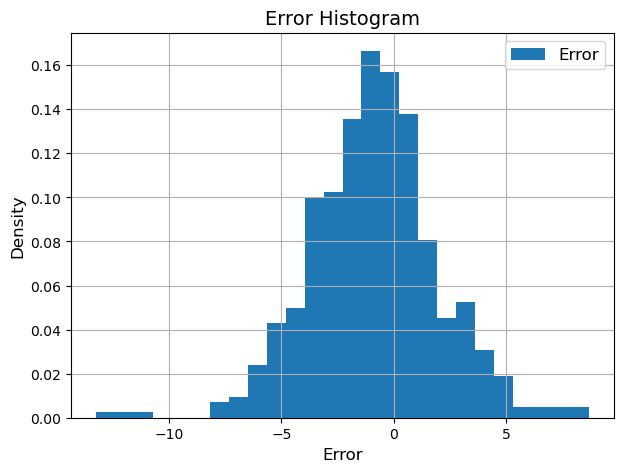

In [253]:
# Plot histogram of error
fig = plt.figure(figsize=(7, 5))
plt.title("Error Histogram",fontsize = 14)
plt.xlabel("Error", fontsize = 12)
plt.ylabel("Density", fontsize = 12)
plt.hist(errors, density=True, bins='auto', histtype='stepfilled', alpha=1, label = "Error")
plt.legend(loc='best', fontsize = 12)
plt.grid()
plt.show()

## <center>B/E Volatility<center>

__<span style="color:blue">For one hedging back-test between $t_{1}$ and $t_{2}$, you can compute the B/E volatility and compare it to the realized one on that same period and compare their difference to the final $P\&L$ and look at for instance a scatter plot of these quantities. </span>__

__<span style="color:blue">You can also compare time series of B/E volatilities to realized ones. If you find implied volatility data, you can also compare to that.</span>__

### B/E Volatility:

Figure out B/E volatility, by solving the equation that error=0.

In [135]:
def BEvol(x):
    # x is volatility
    N = 31
    dt = tenor/N/252
    K = data1['S'][i0-1]
    P0 = CbsD(i0,i0,K,BE = x)
    Pt = P0
    PPath = [P0]

    for j in range(N):
        it = i0 + j*4
        dPt = data1['r'][it-1]*Pt*dt + Delta(i0,it,K,BE = x)*(data1['dS'][it-1]-data1['r'][it-1]*data1['S'][it-1]*dt)
        Pt += dPt
        PPath.append(Pt)
    
    error = PPath[-1]-max(data1['S'][i0+tenor]- K,0)
    return error

In [268]:
from scipy.optimize import root

BEvols = []
for i0 in range(126, 625):
    BEvols.append(root(BEvol,data1['his_vol'][i0],tol=1e-10).x[0])

In [285]:
BE_vol = pd.DataFrame(BEvols,index=rea_vol.index, columns=["BE_vol"])
BE_vol 

,BE_vol
Date,
2021-01-04,0.399871
2021-01-05,0.399958
2021-01-06,0.400037
2021-01-07,0.400032
2021-01-08,0.400100
...,...
2022-12-27,0.358515
2022-12-28,0.358536
2022-12-29,0.358537


In [344]:
win_vol = pd.DataFrame(index=data1.index, columns=["win_vol"])
win_vol = win_vol.loc['2021-01-04':'2023-01-03']

rolling_avg = his_vol['his_vol'].rolling(window=tenor, min_periods=1).mean()

win_vol['win_vol'] = rolling_avg

### Realized Volatility:

Calculate the realized volatility in each time window.

In [345]:
# Initialize the realized volatility dataframe
rea_vol = pd.DataFrame(index=data1.index, columns=["rea_vol"])
rea_vol = rea_vol.loc['2021-01-04':'2023-01-03']

for i in range(len(rea_vol)):
    # roll and use the sigma fomula
    column_sum_of_squares = (logS.iloc[0+i:tenor+i] ** 2).sum()
    rea_vol.iloc[i] = np.sqrt(252/tenor*column_sum_of_squares)

The index is the start day of each time window.

In [287]:
vol = pd.DataFrame(index=data.index)
vol = vol.loc['2021-01-04':'2023-01-03']
vol['his_vol'] = his_vol['his_vol'].loc['2021-01-04':'2023-01-03']
vol['rea_vol'] = rea_vol['rea_vol']
vol['BE_vol'] = BE_vol['BE_vol']
vol['BE_vol'] = BE_vol['BE_vol']
vol['his-BE'] = vol['his_vol']-vol['BE_vol']
vol['rea-BE'] = vol['rea_vol']-vol['BE_vol']
vol

,his_vol,rea_vol,BE_vol,his-BE,rea-BE
Date,,,,,
2021-01-04,0.399871,0.399501,0.399871,0.0,-0.00037
2021-01-05,0.400045,0.40262,0.399958,0.000087,0.002662
2021-01-06,0.400194,0.403073,0.400037,0.000158,0.003037
2021-01-07,0.400018,0.401498,0.400032,-0.000014,0.001466
2021-01-08,0.400372,0.401625,0.400100,0.000272,0.001525
...,...,...,...,...,...
2022-12-27,0.354984,0.350525,0.358515,-0.003531,-0.00799
2022-12-28,0.355221,0.350854,0.358536,-0.003315,-0.007682
2022-12-29,0.353013,0.354495,0.358537,-0.005524,-0.004041


### Scatter Plot

In [ ]:
fig, ax1 = plt.subplots(figsize=(7, 5))
plt.title("The Time Series of the His_vol-BE_vol and P&L",fontsize = 14)

ax1.scatter(vol['his-BE'].index,vol['his-BE'], color='blue',label = 'his_vol-BE_vol')
ax1.scatter(vol['rea-BE'].index,vol['rea-BE'], color='green', marker='*', label = 'rea_vol-BE_vol')
ax1.set_xlabel('Time',fontsize = 11)
ax1.set_ylabel('Difference', color='blue',fontsize = 11)
ax1.set_xticks(list(vol['his-BE'].index)[::30])
ax1.tick_params(axis='x', rotation=45) 

ax2 = ax1.twinx()

ax2.scatter(vol['his-BE'].index[:-1],errors,color='orange', label = '$P&L$')
ax2.set_ylabel('P&L', color='orange',fontsize = 11)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Conclusions:

__1. B/E volatility is quite close to both the historical volatility and the realized volatility in each time window.__

__2. However, there is no significant relationship between the the final $P\&L$ and rea_vol-BE_vol or between the the final $P\&L$ and his_vol-BE_vol.__

__3. Since I cannot find the price information during an option's whole life, I cannot figure out the implied volatility in the time window. So, I did not dig deeply into the implied volatility.__


## <center>B/E Skew<center>

__<span style="color:blue">Be creative, test anything you’d like to understand better. For instance, the B/E skew:
Once you have find the B/E volatility between $t_{1}$ and $t_{2}$ from hedging an ATM call,
you can find the B/E skew, i.e. the parameter $s$ such that hedging an ATM digital
call option has zero $P\&L$. This is done by setting the initial price to $p = p_{bs} + \nu_{bs} × s$
(where $p_{bs}$ is the digital call price in Black-Scholes and $\nu_{bs}$ is the Black-Scholes vega)
and $\Delta = \Delta_{bs} + \frac{\partial \nu_{bs}}{\partial S} × s$ and finding $s$ on a given path that yields a perfect hedging.</span>__

### B/E Skew:

$$\upsilon_{bs} = \frac{\partial c}{\partial \sigma} = S\sqrt{T-t}N'(d_1) = \frac{S\sqrt{T-t}}{\sqrt{2\pi}}e^{-\frac{d_1^2}{2}}$$

\begin{align}
    \frac{\partial \upsilon_{bs}}{\partial S} &= \frac{\mathrm{d} S}{\mathrm{d} S}\sqrt{T-t}N'(d_1)+ S\sqrt{T-t}\frac{\partial N'(d_1)}{\partial S} \\
     &= \frac{\mathrm{d} S}{\mathrm{d} S}\sqrt{T-t}N'(d_1)+ S\sqrt{T-t}\frac{\mathrm{d} N'(d_1)}{\mathrm{d} d_1}\frac{\partial d_1}{\partial S} \\
     &= \frac{\sqrt{T-t}}{\sqrt{2\pi}}e^{-\frac{d_1^2}{2}}-\frac{S\sqrt{T-t}}{\sqrt{2\pi}}e^{-\frac{d_1^2}{2}}\frac{d_1}{\sigma\sqrt{T-t}S} \\
     &=(\sqrt{T-t}-\frac{d_1}{\sigma})N'(d_1)
\end{align}

In [351]:
def Vega(i0,it,K,BE):
    return data1['S'][it-1]*np.sqrt((i0+tenor-it)/252)*norm.pdf(d(i0,it,K,BE)[0])

In [350]:
def VegaS(i0,it,K,BE):
    return (np.sqrt((i0+tenor-it)/252)-d(i0,it,K,BE)[0]/data1['his_vol'][it])*norm.pdf(d(i0,it,K,BE)[0])

In [357]:
def PerfectError(s):
    
    N = 31
    dt = tenor/N/252
    K = data1['S'][i0-1] #ATM
    BE = False
    P0 = CbsD(i0,i0,K,BE)+Vega(i0,i0,K,BE)*s
    Pt = P0
    PE_PPath = [P0]
    PE_times = []
    for j in range(N):
        it = i0 + j*4
        times.append(data1.index[it])
        local_delta = Delta(i0,it,K,BE)+VegaS(i0,it,K,BE)*s
        dPt = data1['r'][it-1]*Pt*dt + local_delta*(data1['dS'][it-1]-data1['r'][it-1]*data1['S'][it-1]*dt)
        Pt += dPt
        PE_PPath.append(Pt)
    
    error = PE_PPath[-1]-(max(data1['S'][i0+tenor]- K,0))
    PE_times.append(data1.index[i0+tenor])
    return error

In [358]:
# Test
i0 = 126
solution = root(PerfectError,0.0001,tol=1e-10)

 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00]
       x: [-1.259e+00]
    nfev: 10
    fjac: [[-1.000e+00]]
       r: [-4.584e+00]
     qtf: [ 8.882e-16]

In [366]:
from scipy.optimize import root

ss = []
for i0 in range(126, 625):
    ss.append(root(PerfectError,0.0001,tol=1e-10).x[0])

Plot the $s$ in each time window into this histogram.

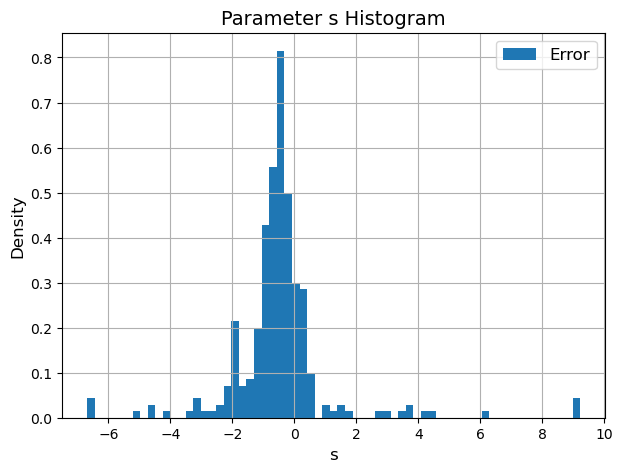

In [368]:
# Plot parameter s
fig = plt.figure(figsize=(7, 5))
plt.title("Parameter s Histogram",fontsize = 14)
plt.xlabel("s", fontsize = 12)
plt.ylabel("Density", fontsize = 12)
plt.hist(ss, density=True, bins='auto', histtype='stepfilled', alpha=1, label = "Error")
plt.legend(loc='best', fontsize = 12)
plt.grid()
plt.show()

$s$ is as above shows.

### <center>END<center>